# Quantum benchmark

## I - Introduction

## II - Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score, KFold
#Import classical libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import functools

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
import logging

import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer

from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
import qiskit

In [2]:
import warnings
warnings.filterwarnings('ignore')

## III - Data 

In [3]:
# Read out CSV

df = pd.read_csv('fraud_detection_bank_dataset.csv', sep=',')

In [3]:
%%script false --no-raise-error

import sweetviz as sv

#EDA using Autoviz
sweet_report = sv.analyze(df)

#Saving results to HTML file
sweet_report.show_html('sweet_report.html')

## IV - Modelisation

## Quantum Approaches

In [4]:
from sklearn.decomposition import TruncatedSVD

In [6]:
from sklearn.preprocessing import StandardScaler

In [9]:
df = df.drop(['Unnamed: 0'], axis = 1)
df_labels = df['targets']
df.drop(['targets'],axis = 1,inplace = True)
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=42)

In [22]:
cols = ['col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_18', 'col_19','col_20', 'col_21', 'col_35', 
        'col_51', 'col_52', 'col_53', 'col_70','col_71','col_7', 'col_22', 'col_54', 'col_56']

X_train = X_train.drop(cols, axis=1)
X_test = X_test.drop(cols, axis=1)

In [23]:
# Standardizing the features
x = StandardScaler().fit_transform(X_train)

In [24]:
qla = TruncatedSVD(n_components=2)

In [25]:
qla.fit(x)

TruncatedSVD()

In [26]:
df_qla = qla.transform(x)

In [27]:
principalDf = pd.DataFrame(data = df_qla
             , columns = ['principal component 1', 'principal component 2'])

In [28]:
principalDf.head()

,principal component 1,principal component 2
0,-0.752511,-2.507922
1,-1.287880,1.747014
2,2.543801,-7.181829
3,7.663359,-1.668144
4,-1.210011,1.212229


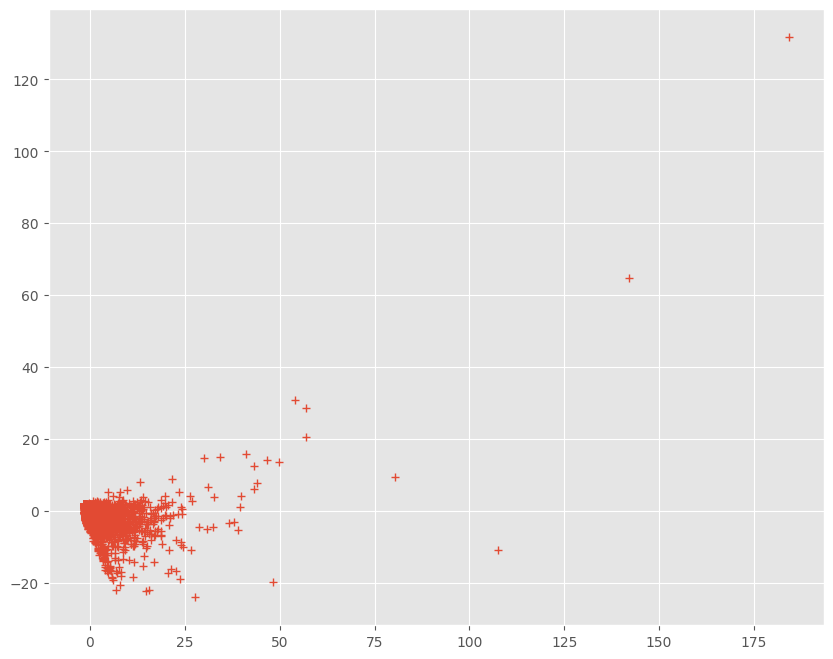

In [29]:
plt.figure(figsize=(10,8))
plt.plot(principalDf.iloc[:,0], principalDf.iloc[:,1], '+')
#plt.plot(df.index, feature_2, 'g+')

In [30]:
n_dim = len(principalDf.columns)

## Split train test 

In [31]:
# Split dataset into train and test

sample_train, sample_test, label_train, label_test = train_test_split(
     principalDf, y_train, test_size=0.2, random_state=22)

# Normalize

std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale for better fit within the feature map

samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select a sample for a better control of the research and wall time

train_size = 800#160
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 200 #40
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [32]:
# Basic parameters for hybrid model

seed = 8500
feature_dim = 2#n_dim
num_reps = 2
num_shots =256 


## Hybrid

In [33]:
# Define feature_map

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=num_reps)

# Define the backend
backend = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=num_shots, seed_simulator=seed, seed_transpiler=seed
)

# Define the kernel

kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

# Model run
svc = SVC(kernel=kernel.evaluate)
#svc.fit(sample_train, label_train)
#score = svc.score(sample_test, label_test)

#print(f"Callable kernel classification test score: {score}")

In [70]:
#result_predict = svc.predict(sample_test)

In [21]:
#print(metrics.classification_report(label_test,result_predict))

## Classical Approaches

In [34]:
from sklearn.model_selection import cross_validate
from tqdm import tqdm
def evaluate_ml_model(_models, X, y, n_fold=10, metric='precision'):
    ''' Function to evaluate a ML and QML model with a list of metrics
    
    
    '''
    results = pd.DataFrame()
    kfold = KFold(n_splits=n_fold)
    columns = []
    for name, model in tqdm(_models):
        # -------------------
        # Variables initialization 
        _df = pd.DataFrame()
        names = []
        means = []
        stds = []
        
        # -------------------
        # k-fold Cross validation
        cv_results = cross_validate(model, X, y, cv=kfold, scoring=metric)
        
        # -------------------
        # Compute the mean and standard deviation 
        for _name, _array in cv_results.items():
            names.append(_name)
            means.append(round(100*_array.mean(), 2))
            stds.append(round(100*_array.std(), 2))
        # -------------------
        # Save the results in a dataframe 
        _df =  pd.DataFrame([means, stds], columns=names)
        columns.extend([name+' mean (%)', name+' std (%)'])
        #results = results.join(_df, on=_df.index)
        results = results.append(_df)
    results.index = columns
    print(results)
    return results

In [35]:
models = []
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('qsvc', svc))
_metrics = ['precision', 'recall', 'f1', 'accuracy',  'matthews_corrcoef','balanced_accuracy']

In [36]:
df_results = pd.DataFrame()

In [37]:
df_results = evaluate_ml_model(models, sample_train, label_train, n_fold=10, metric=_metrics)

                fit_time  score_time  test_precision  test_recall  test_f1  \
LR mean (%)      0.00134     0.00121         0.00000      0.00000  0.00000   
LR std (%)       0.00030     0.00012         0.00000      0.00000  0.00000   
KNN mean (%)     0.00030     0.00194         0.74391      0.55268  0.62767   
KNN std (%)      0.00005     0.00009         0.12999      0.12668  0.11153   
CART mean (%)    0.00089     0.00108         0.54468      0.57241  0.55478   
CART std (%)     0.00004     0.00003         0.11339      0.08939  0.09600   
NB mean (%)      0.00026     0.00108         0.84667      0.08838  0.15615   
NB std (%)       0.00002     0.00005         0.20396      0.03876  0.06020   
SVM mean (%)     0.00368     0.00299         0.00000      0.00000  0.00000   
SVM std (%)      0.00017     0.00010         0.00000      0.00000  0.00000   
qsvc mean (%)  231.33997    52.93259         0.00000      0.00000  0.00000   
qsvc std (%)     8.21758     7.33990         0.00000      0.0000

In [38]:
df_results

,fit_time,score_time,test_precision,test_recall,test_f1,test_accuracy,test_matthews_corrcoef,test_balanced_accuracy
LR mean (%),0.00134,0.00121,0.00000,0.00000,0.00000,0.74625,0.00000,0.50000
LR std (%),0.00030,0.00012,0.00000,0.00000,0.00000,0.03262,0.00000,0.00000
KNN mean (%),0.00030,0.00194,0.74391,0.55268,0.62767,0.84125,0.54333,0.74461
KNN std (%),0.00005,0.00009,0.12999,0.12668,0.11153,0.02503,0.11857,0.06199
CART mean (%),0.00089,0.00108,0.54468,0.57241,0.55478,0.76875,0.40152,0.70349
CART std (%),0.00004,0.00003,0.11339,0.08939,0.09600,0.05039,0.12289,0.05979
NB mean (%),0.00026,0.00108,0.84667,0.08838,0.15615,0.76250,0.21378,0.54001
NB std (%),0.00002,0.00005,0.20396,0.03876,0.06020,0.03112,0.06515,0.01795
SVM mean (%),0.00368,0.00299,0.00000,0.00000,0.00000,0.74500,-0.00606,0.49919
SVM std (%),0.00017,0.00010,0.00000,0.00000,0.00000,0.03172,0.01819,0.00242


## QSVC

In [ ]:
# Be assure that your qiskit version is 0.4.0
# run !pip install --upgrade qiskit==0.4.0 if not 

In [39]:
%%script false --no-raise-error
# Define feature_map, optimizer and var_form

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
optimizer = COBYLA(maxiter=20, disp=True, rhobeg=1.0, tol=None)
var_form = TwoLocal(feature_dim, ['ry', 'rz'], 'cz', reps=3)


# Define the backend

backend = qiskit.Aer.get_backend('qasm_simulator')

# Define the instance

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

# Model run
vqc = QSVC(quantum_kernel=quantum_instance)#optimizer, feature_map, var_form, training_input, test_input, datapoints[0])


result = vqc.fit(sample_train, label_train)



In [40]:
import qiskit
qiskit.__version__

'0.21.1'

In [33]:
!pip3 install --upgrade qiskit #==0.4.0

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


## Pennylane

In [41]:
from pennylane import numpy as np

In [42]:
# Angle Encoding

num_qubits = n_dim

dev = qml.device('default.qubit', wires = num_qubits)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [43]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

#print(weights_init, bias_init)

In [44]:
circuit(weights_init, sample_train[0])

tensor(0.54732857, requires_grad=True)

In [45]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [46]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [47]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [48]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [49]:
Y = np.array(label_train * 2 - np.ones(len(label_train)),requires_grad=True)  # shift label from {0, 1} to {-1, 1}
X = np.array(sample_train, requires_grad=True)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

X = [tensor(-0.99341934, requires_grad=True), tensor(-0.68815636, requires_grad=True)], Y = -1
X = [tensor(-0.99429376, requires_grad=True), tensor(-0.67655443, requires_grad=True)], Y = -1
X = [tensor(-0.96475475, requires_grad=True), tensor(-0.67687098, requires_grad=True)], Y = -1
X = [tensor(-0.99353895, requires_grad=True), tensor(-0.67725454, requires_grad=True)], Y = -1
X = [tensor(-0.98894799, requires_grad=True), tensor(-0.69071348, requires_grad=True)], Y = -1


In [50]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [56]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0
ccost = 0 
for it in range(150):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    prec = metrics.f1_score(Y, predictions, average='binary', pos_label=1)
    if  prec > abest or ((prec == abest) and (cost(weights, bias, X, Y) < ccost)):
        wbest = weights
        bbest = bias
        abest = prec
        ccost = cost(weights, bias, X, Y)
        print('New best')
    #prec = metrics.precision_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | f1: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

New best
Iter:     1 | Cost: 1.4937741 | f1: 0.4047856 
New best
Iter:     2 | Cost: 1.0040515 | f1: 0.4171123 
Iter:     3 | Cost: 0.7622794 | f1: 0.0000000 
Iter:     4 | Cost: 0.8079441 | f1: 0.0000000 
Iter:     5 | Cost: 0.9365097 | f1: 0.0000000 
Iter:     6 | Cost: 0.9992449 | f1: 0.0000000 
Iter:     7 | Cost: 0.9865623 | f1: 0.0000000 
Iter:     8 | Cost: 0.9493846 | f1: 0.0000000 
Iter:     9 | Cost: 0.8797505 | f1: 0.0000000 
Iter:    10 | Cost: 0.8216910 | f1: 0.0000000 
Iter:    11 | Cost: 0.7739921 | f1: 0.0000000 
Iter:    12 | Cost: 0.7544736 | f1: 0.0000000 
Iter:    13 | Cost: 0.8364440 | f1: 0.0000000 
Iter:    14 | Cost: 0.9298691 | f1: 0.0384615 
Iter:    15 | Cost: 0.9247190 | f1: 0.0289855 
Iter:    16 | Cost: 0.9031347 | f1: 0.0097561 
Iter:    17 | Cost: 0.8211278 | f1: 0.0000000 
Iter:    18 | Cost: 0.7671225 | f1: 0.0000000 
Iter:    19 | Cost: 0.7518270 | f1: 0.0000000 
Iter:    20 | Cost: 0.7568464 | f1: 0.0000000 
Iter:    21 | Cost: 0.8002544 | f1: 0.0000

In [57]:
Yte = np.array(label_test * 2 - np.ones(len(label_test)))
Xte = np.array(normalize(sample_test))

In [58]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.8710350271237085, Accuracy: 76.0%


In [59]:
print(metrics.classification_report(predictions,Yte))

              precision    recall  f1-score   support

        -1.0       0.99      0.77      0.87       199
         1.0       0.00      0.00      0.00         1

    accuracy                           0.77       200
   macro avg       0.50      0.38      0.43       200
weighted avg       0.99      0.77      0.86       200



In [60]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    ''')



    Precision: 0.0%
    Recall: 0.0%
    f1: 0.0%
    Accuracy: 76.5%
    Balanced accuracy: 38.44%
    Matthew corcorref: -3.87%
    
